# AI on the edge

Deep learning on small devices


## About StackUp
---

![stackup](assets/stackup.png)

## AI on the edge
---
- Motivation
- Deep nets for devices
- Running deep nets on devices

## The Why
---
Why run AI on the edge?

![cloud](assets/lsvm-machine-learning-cloud.jpg)

![data center](assets/how_safe_datacenter.jpg)

<img src='assets/GDP-Complience-V02-72dpi-RGB-01.jpg' width='70%'/>

<img src='assets/qualcomm_on_device_intelligence.png' width='80%'/>

## Optimized deep learning models
---
What AI can run on small devices?


*small = smaller than mobile phones

## Optimized deep learning models
---
What AI can run **in real time** on small devices?

*small = smaller than mobile phones

## AlexNet (2012) (baseline)

<img src="assets/alexnet.png" width='60%'/>

How many parameters? How many operations?

## AlexNet (2012) (baseline)

60 million parameters

720 million multiply-add operations

## Compression?

## SqueezeNet (2016)

<img src='assets/squeezenet_unit.png' width='800'/>

[source](https://github.com/DeepScale/SqueezeNet)

<img src='assets/squeezenet_compare.png' width='60%'/>
<img src='assets/squeezenet_bypass.png' width='60%'/>

## Do less?

## MobileNet (2017)

<img src='assets/depthwise_separable_conv_layer.png' width='400' style='float:right;'/>
Convolution:

$$h_i.w_i.d_i.d_j.k^2$$

Depthwise separable convolution:

$$h_i.w_i.d_i(d_j+k^2)$$

[paper](https://arxiv.org/abs/1704.04861v1)

<img src='assets/mobilenet_acc.png' width='40%'/>

## More efficient operations?

## ShuffleNet (2017)

<img src='assets/shufflenet_channelshuffle.png'/>

[paper](https://arxiv.org/abs/1707.01083)

<img src='assets/shufflenet_compare_class.png'/>

## Get some accuracy back?

## MobileNet V2 (2018)

<img src='assets/mobilenetv2_footprint.png' style='float:right;' width='50%'/>
Convolution: 

$h_i.w_i.d_i.d_j.k^2$

Depthwise separable (MobileNet V1):

$h_i.w_i.d_i(d_j+k^2)$

Bottleneck + residuals (MobileNet V2):

$h_i.w_i.d_i.t(d_i+d_j+k^2)$

[paper](https://arxiv.org/abs/1801.04381)

<img src='assets/mobilenetv2_block_compare.png' width='55%'/>

<img src='assets/mobilenetv2_compare.png' width='55%'/>

<img src='assets/mobilenetv2_curve.png' width='80%'/>

## Goodbye cloud AI
---
Running* deep learning models on devices

*running = evaluating, not training (yet)

## iOS: CoreML

- download pre-trained .mlmodel
  - or convert from Caffe, Tensorflow, ONNX (Open Neural Network eXchange)
- add to XCode project to generate wrapper
  - use optional Vision library to preprocess images

[docs](https://developer.apple.com/documentation/coreml)

## Demo: Image Classification
---
CoreML on iOS Simulator

Credits: [github](https://github.com/hollance/MobileNet-CoreML)

|MobileNet|SqueezeNet|
|--|--|
|<img src='assets/coreml_mobilenet.png' width='400'/>|<img src='assets/coreml_sqeezenet.png' width='400'/>|

## Android / Linux: TensorFlow & TensorFlow Lite

- Compilable to Raspbian
- TensorFlow Lite: optimized for Android, iOS

<img src='assets/tflite-architecture.jpg' width='500'/>

## Demo: Image Classification
---
Raspberry Pi 3 with TensorFlow

In [3]:
from __future__ import print_function
import sys
import platform
print(", ".join(platform.uname()))

from IPython import display
import numpy as np
import PIL
import tensorflow as tf
print("TensorFlow: ", tf.__version__)

# model stuff
sys.path += ['/models/research/slim']
from datasets import imagenet
from nets.mobilenet import mobilenet_v2

Linux, ac4e95859bdd, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 
TensorFlow:  1.8.0


In [5]:
# download a recent MobileNet V2 checkpoint# downl 
checkpoint_name = 'mobilenet_v2_1.0_224'
checkpoint = checkpoint_name + '.ckpt'
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'

!curl -L {url} -o {checkpoint_name}.tgz
!tar -xvf {checkpoint_name}.tgz

display.clear_output()
print('Downloaded', url, 'as', checkpoint)

Downloaded https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_224.tgz as mobilenet_v2_1.0_224.ckpt


In [10]:
# Setup image processing
tf.reset_default_graph()

file_input = tf.placeholder(tf.string, ())
image = tf.image.decode_jpeg(tf.read_file(file_input))
images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))

In [11]:
# Get the model endpoints
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  
# Restore using exponential moving average for (1.5-2%) higher accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  388k  100  388k    0     0   149k      0  0:00:02  0:00:02 --:--:--  149k
INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt
CPU times: user 3.84 s, sys: 148 ms, total: 3.99 s
Wall time: 2.81 s
Top 1 prediction:  475 cardigan 0.11903315


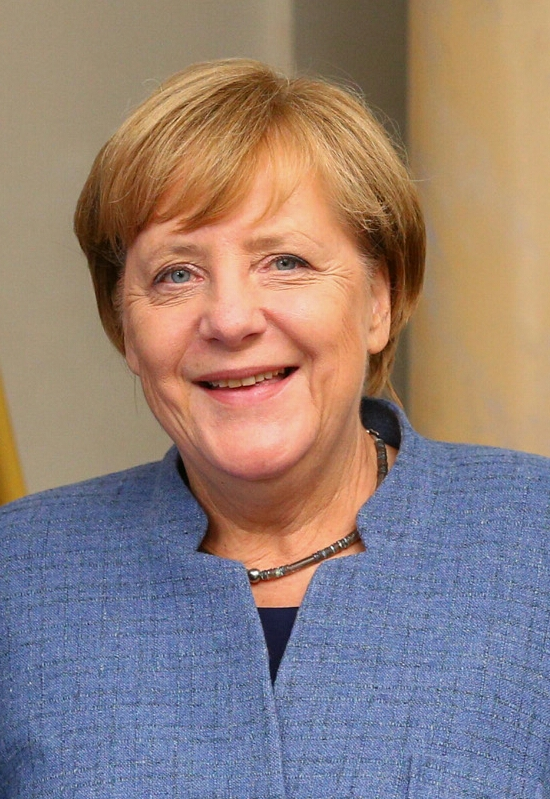

In [13]:
# Download test image
!curl -L -o test.jpg 'https://upload.wikimedia.org/wikipedia/commons/b/bf/Angela_Merkel._Tallinn_Digital_Summit.jpg'

# Restore from checkpoint and do prediction
with tf.Session() as sess:
    saver.restore(sess,  checkpoint)
    %time y = endpoints['Predictions'].eval(feed_dict={file_input: 'test.jpg'})

label_map = imagenet.create_readable_names_for_imagenet_labels()
print('Top 1 prediction: ', y.argmax(), label_map[y.argmax()], y.max())
display.display(display.Image('test.jpg', width=128))

## Offload: Movidius Neural Compute Stick

<img src='assets/ncs_workflow.jpg'/>

[SDK](https://github.com/movidius/ncsdk) for Python, C++ | [Models](https://github.com/movidius/ncappzoo/) for Caffe, TensorFlow

<img src='assets/NCS1_ArchDiagram.jpg'/>

<img src='assets/pi_ncs_objectdetection_table.jpg'/>

[study](https://www.pyimagesearch.com/2018/02/19/real-time-object-detection-on-the-raspberry-pi-with-the-movidius-ncs/)

## Demo: Object Detection
---
Raspberry Pi 3 + Movidius in Python

In [69]:
from __future__ import print_function
import os
import sys
import platform

import mvnc.mvncapi as mvapi
mvapi.SetGlobalOption(mvapi.GlobalOption.LOG_LEVEL, 0)

# utilities
sys.path += ['/ncappzoo/apps/ssd-object-detector']
from utils import deserialize_output

In [70]:
import numpy as np
import skimage.io
import skimage.transform
import PIL
from IPython import display

# pre-process the test image
IMAGE = 'assets/rub.jpg'
MEAN = 127.5
SCALE = 0.00789

raw_image = skimage.io.imread(IMAGE)
image = skimage.transform.resize(raw_image, [300, 300], preserve_range=True)
image = image[:, :, ::-1] # RGB -> BGR
image = image.astype(np.float16)
image = (image - np.float16(MEAN)) * SCALE

In [71]:
# load the labels
LABELS = '/ncappzoo/caffe/SSD_MobileNet/labels.txt'

labels = [line.rstrip('\n') for line in open(LABELS) if line != 'classes\n']

Linux, raspberrypi, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 
opened Movidius:  1.4
loaded graph:  /ncappzoo/caffe/SSD_MobileNet/graph
execution time: 80.6337 ms
96.0%	15: person: Top Left: (121, 24) Bottom Right: (300, 241)
96.0%	15: person: Top Left: (14, 128) Bottom Right: (300, 299)


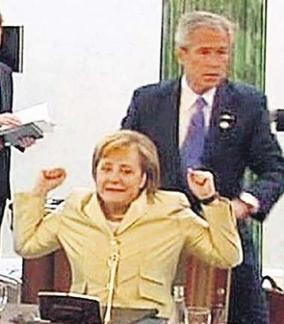

In [72]:
GRAPH = '/ncappzoo/caffe/SSD_MobileNet/graph'

ncs_name = mvapi.EnumerateDevices()[0] # pick the first device
movidius = mvapi.Device(ncs_name)

print(", ".join(platform.uname()))

try:
    movidius.OpenDevice()
    print('opened Movidius: ', ncs_name)

    with open(GRAPH, mode='rb') as f:
        blob = f.read()
    graph = movidius.AllocateGraph(blob)
    print('loaded graph: ', GRAPH)

    # warm start with a dummy forward pass
    graph.LoadTensor(image, 'user object')
    output, userobj = graph.GetResult()

    # actual timed inference
    graph.LoadTensor(image, 'user object')
    output, userobj = graph.GetResult()
    inference_time = graph.GetGraphOption(mvapi.GraphOption.TIME_TAKEN)
    
    # deserialize and print output
    CONFIDENCE_THRESHOLD = 0.60
    output_dict = deserialize_output.ssd(output, CONFIDENCE_THRESHOLD, image.shape)

    print("execution time:", str(np.sum(inference_time)), "ms")

    for i in range(0, output_dict['num_detections']):
        print("%3.1f%%\t" % output_dict['detection_scores_' + str(i)]
               + labels[int(output_dict['detection_classes_' + str(i)])]
               + ": Top Left: " + str(output_dict['detection_boxes_' + str(i)][0])
               + " Bottom Right: " + str(output_dict['detection_boxes_' + str(i)][1]))

    display.display(display.Image(IMAGE))

finally:
    graph.DeallocateGraph()
    movidius.CloseDevice()

## Any device: Embedded Learning Library

[Open source library](https://microsoft.github.io/ELL/) developed by Microsoft Research

Uses [OpenBLAS](https://www.openblas.net/) for fast matrix operations

Runs on CPU

[LLVM](https://llvm.org/) optimizer and cross compiler to target embedded platforms

Library of optimized pre-trained models: image classification, keyword detection, transfer learning

Trade off speed and accuracy

## Workflow

<img src='assets/ell_workflow.png' width='50%'/>

## Speed vs. accuracy tradeoff

<img src='assets/ell_pareto.png'/>

<img src='assets/ell_tiny.png'/>

[model file](https://microsoft.github.io/ELL/gallery/ILSVRC2012/BrazilianGuava.html)

## Demo: Image Classification

---

Raspberry Pi 3

[DNN Architecture](https://raw.githubusercontent.com/Microsoft/ELL-models/master/models/ILSVRC2012/Chalta/Chalta.cntk.svg?sanitize=true)

In [5]:
# https://microsoft.github.io/ELL/tutorials/Getting-started-with-image-classification-on-the-Raspberry-Pi/

from __future__ import print_function
import sys
import platform
print(", ".join(platform.uname()))
import numpy as np
from matplotlib import pyplot as plt

import cv2
print("OpenCV: ", cv2.__version__)

Windows, ISS8361007390, 10, 10.0.15063, AMD64, Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
OpenCV:  3.4.1


In [ ]:
# load the Object Classifier ELL model
# We are using: https://microsoft.github.io/ELL/gallery/ILSVRC2012/Chalta.html
sys.path += ["/object-classifier/pi3", "/object-classifier/pi3/build", "/"]
import tutorial_helpers as helpers
import model

input_shape = model.get_default_input_shape()
output_shape = model.get_default_output_shape()

# get the labels
with open("/object-classifier/categories.txt", "r") as categories_file:
    categories = categories_file.read().splitlines()

In [13]:
# get the test image
IMAGE = 'assets/dog.jpg'

image = cv2.imread(IMAGE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_data = helpers.prepare_image_for_model(
    image_rgb, input_shape.columns, input_shape.rows, reorder_to_rgb=False, ravel=True)

CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 179 ms
(73%) Arctic fox, white fox, Alopex lagopus, (24%) white wolf, Arctic wolf, Canis lupus tundrarum


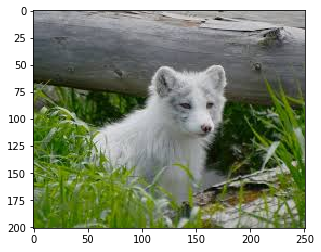

In [14]:
# call the model
%time predictions = model.predict(input_data)

# process the result
top_5 = helpers.get_top_n(predictions, 5)

header_text = ", ".join(["({:.0%}) {}".format(
    element[1], categories[element[0]]) for element in top_5])

plt.imshow(image_rgb)
print(header_text)

## Even smaller?
---
[MXChip IoT DevKit](https://microsoft.github.io/azure-iot-developer-kit/)

<img src='assets/mxweb-12.png' style='float:left;' width='50%'/><img src='assets/EMW3166.png' style='float:right;' width='50%'/>

## ELL Keyword Classification on Cortex M4F

[Keyword classification tutorial](https://microsoft.github.io/ELL/tutorials/Getting-started-with-audio-keyword-classification-on-the-Raspberry-Pi/)

---
<video controls src='assets/ell_demo.mp4'/>

In [ ]:
# https://microsoft.github.io/ELL/tutorials/Getting-started-with-audio-keyword-classification-on-the-Raspberry-Pi/

from __future__ import print_function
import os
import sys
import platform
print(", ".join(platform.uname()))
import numpy as np

# load the ELL audio helper code
sys.path += ["/ELL/tools/utilities/pythonlibs/audio"]
import classifier
import featurizer
import wav_reader

In [ ]:
CLASSIFIER = "/speech-cmds/classifier_16k/model"
FEATURIZER = "/speech-cmds/featurizer_16k/mfcc"
CATEGORIES = "/speech-cmds/categories.txt"

THRESHOLD = 0.6 # only report predictions with greater than 60% confidence
SAMPLE_RATE = 16000 # classifier was trained on 16kHz samples
CHANNELS = 1 # classifier was trained on mono audio
SMOOTHING = 0.2 # 0.2 second smoothing window on classifier output
NOISE_LABEL = [0] # tell classifier to ignore predictions of background noise

predictor = classifier.AudioClassifier(CLASSIFIER, CATEGORIES, NOISE_LABEL, THRESHOLD, SMOOTHING)
transform = featurizer.AudioTransform(FEATURIZER, predictor.input_size)

In [ ]:
wav_file = '/ELL/docs/tutorials/Getting-started-with-audio-classification-on-the-Raspberry-Pi/seven.wav'

reader = wav_reader.WavReader(SAMPLE_RATE, CHANNELS)
reader.open(wav_file, transform.input_size)
transform.open(reader)

In [ ]:
while True:
    feature_data = transform.read()
    if feature_data is None:
        break
    else:
        prediction, probability, label = predictor.predict(feature_data)
        if probability is not None:          
            percent = int(100 * probability)
            print("<<< DETECTED ({}) {}% {} >>>".format(prediction, percent, label))

Test data: https://www.text2speech.org/

In [ ]:
!cat /speech-cmds/categories.txt

In [ ]:
# !curl -o speech.wav -L 'https://www.text2speech.org/FW/getfile.php?file=3826f2e422a656b3920c9c315a296924%2Fspeech.wav'
# !curl -o speech.wav -L 'https://www.text2speech.org/FW/getfile.php?file=5eb5956a8853bccf26bd721e798589c3%2Fspeech.wav'
# wav_file = 'speech.wav'

## Programmable hardware?
---
<img src='assets/Hot-Chips-Stratix-10-board-1-.jpg'/>

<img src='assets/silicon_alternatives.png'/>

https://www.microsoft.com/en-us/research/blog/microsoft-unveils-project-brainwave/

## FPGA: Neural Net Accelerators
- [comparison study](https://arxiv.org/abs/1712.08934)
- [Xilinx](https://github.com/Xilinx/RFNoC-HLS-NeuralNet)
- [PipeCNN](https://github.com/doonny/PipeCNN)

<img src='assets/Demo-DE5-net.gif'/>

## Deploy to an FPGA via Azure
---
[Azure Real Time AI: ResNet50](https://github.com/Azure/aml-real-time-ai/blob/master/notebooks/resnet50/00_QuickStart.ipynb)

## What we covered

- Running AI on devices _can_ improve responsiveness, address privacy risks

- Optimized deep learning models are available today

- Many ways to deploy models on devices
  - CoreML
  - TensorFlow / TensorFlow Lite
  - Offloaded (e.g. Movidius)
  - Embedded Learning Library
  - FPGAs

## Thank you!
---
<img src='assets/stackup-banner.png' style='float:left;'/>
<img src='assets/fb-128x128.png' width='96'/>facebook.com/groups/stackup
<img src='assets/Octicons-mark-github.svg' width='5%'/>github.com/lisaong/stackup-workshops

[Survey](https://www.mentimeter.com/s/21766e2bbf0395ac216695c825dab352/4945f7d8aea3)

## Bonus Demo
---
Visualizing MobileNet V1 using Keras on Raspberry Pi 3

In [1]:
# Reference: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

# if running on python 3.6, may need this:
# !conda install pillow=4.1.1

import numpy as np
import platform
print(", ".join(platform.uname()))
import keras
print("Keras:", keras.__version__)
from keras.applications import mobilenet
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
from matplotlib.pyplot import imshow
import time

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128
img_path = 'assets/dog.jpg'

# Load a MobileNet network with ImageNet weights
print('Loading MobileNet v1 ....')
model = mobilenet.MobileNet(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

model.summary()

Linux, bb9db747cd55, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 


/usr/lib/python3/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras: 2.1.6
Loading MobileNet v1 ....
17227776/17225924 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
______________________________________

In [2]:
def preprocess_image(image_path):
    """Opens, resize and format pictures into tensors"""
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = mobilenet.preprocess_input(img)
    return img

def deprocess_image(x):
    """Converts a tensor into a valid image"""
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    """Normalizes a tensor by its L2 norm""" 
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [3]:
# name of the layer and max number of filters to visualize
# (see model definition at keras/applications/mobilenet.py)
layer_name = 'conv_dw_3'
max_filters = 32
epochs = 30

input_img = model.input
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

kept_filters = [] # candidate filters to display

for filter_index in range(max_filters):

    # scan through the first max_filters filters
    # max_filters must be less than the actual number of filters in each layer
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # ==========================================
    # 1. build a loss function that maximizes the activation
    #    of the nth filter of our selected layer
    layer_output = layer_dict[layer_name].output    
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
   
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    
    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # return the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    
    # ==========================================
    # 2. now run gradient ascent
    input_img_data = preprocess_image(img_path)
    step_size = 1.
    
    for i in range(epochs):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step_size

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # ===========================================
    # 3. decode the resulting input image and store in kept_filters
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 1.746841
Current loss value: 1.5390297
Current loss value: 2.74441
Current loss value: 3.635646
Current loss value: 4.3795075
Current loss value: 5.013916
Current loss value: 5.521706
Current loss value: 5.970072
Current loss value: 6.347291
Current loss value: 6.8545547
Current loss value: 7.253422
Current loss value: 7.5773053
Current loss value: 7.9600377
Current loss value: 8.186979
Current loss value: 8.385626
Current loss value: 8.864298
Current loss value: 9.141331
Current loss value: 9.305442
Current loss value: 9.565673
Current loss value: 9.800308
Current loss value: 10.025774
Current loss value: 10.154406
Current loss value: 10.264089
Current loss value: 10.381666
Current loss value: 10.601126
Current loss value: 10.822943
Current loss value: 10.864773
Current loss value: 10.969705
Current loss value: 11.132976
Current loss value: 11.407114
Filter 0 processed in 16s
Processing filter 1
Current loss value: -12.047959
Filter 1 processed 

Current loss value: 10.028311
Current loss value: 28.349066
Current loss value: 30.44645
Current loss value: 31.969765
Current loss value: 32.914932
Current loss value: 33.531937
Current loss value: 33.933372
Current loss value: 34.37256
Current loss value: 34.409306
Current loss value: 34.61219
Current loss value: 34.839718
Current loss value: 35.106922
Current loss value: 35.105335
Current loss value: 35.220497
Current loss value: 35.29332
Current loss value: 35.31762
Current loss value: 35.39327
Current loss value: 35.45862
Current loss value: 35.41832
Current loss value: 35.50872
Current loss value: 35.51449
Current loss value: 35.48281
Current loss value: 35.4405
Current loss value: 35.470078
Current loss value: 35.493946
Current loss value: 35.548077
Current loss value: 35.49018
Current loss value: 35.549232
Current loss value: 35.52014
Current loss value: 35.526276
Filter 18 processed in 17s
Processing filter 19
Current loss value: 0.0039050959
Current loss value: 0.05449607
Cur

16


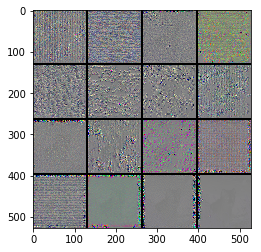

In [4]:
# ===========================================
# 4. stich the best 16 filters on a 4 x 4 grid.
n = 4
print(len(kept_filters))

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 16 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 4 x 4 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img


imshow(stitched_filters)